
## **Step 2 — Dataset Exploration**: Cats vs Dogs 


In [4]:
! pip install tensorflow

'pip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [5]:
! pip install numpy

'pip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [6]:

import os
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [7]:
# Configure paths
from pathlib import Path

BASE_DIR = Path("cats_and_dogs_filtered")
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "validation"

for p in [BASE_DIR, TRAIN_DIR, VAL_DIR]:
    print(f"{p}: {'OK' if p.exists() else 'MISSING'}")


cats_and_dogs_filtered: OK
cats_and_dogs_filtered\train: OK
cats_and_dogs_filtered\validation: OK


In [8]:

def count_images_in(dirpath: Path):
    cats_dir = dirpath / "cats"
    dogs_dir = dirpath / "dogs"
    cats = [f for f in cats_dir.glob("*") if f.is_file()]
    dogs = [f for f in dogs_dir.glob("*") if f.is_file()]
    return len(cats), len(dogs)

train_cats, train_dogs = count_images_in(TRAIN_DIR) if TRAIN_DIR.exists() else (0,0)
val_cats, val_dogs     = count_images_in(VAL_DIR)   if VAL_DIR.exists() else (0,0)

print(f"Training cats: {train_cats}")
print(f"Training dogs: {train_dogs}")
print(f"Validation cats: {val_cats}")
print(f"Validation dogs: {val_dogs}")


Training cats: 1000
Training dogs: 1000
Validation cats: 500
Validation dogs: 500


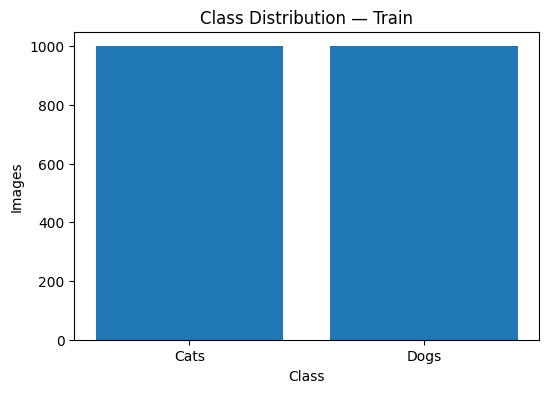

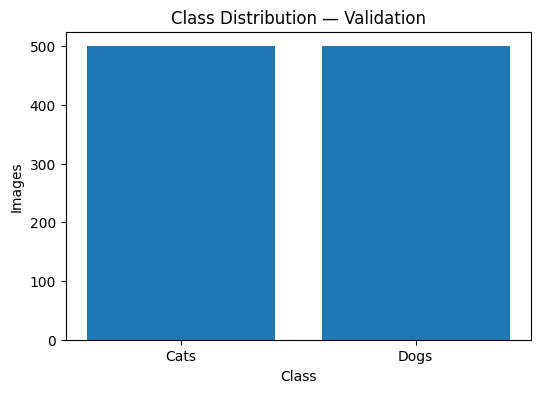

In [9]:

# Bar chart: Train
labels = ["Cats", "Dogs"]
train_counts = [train_cats, train_dogs]
val_counts = [val_cats, val_dogs]

plt.figure(figsize=(6,4))
plt.bar(labels, train_counts)
plt.title("Class Distribution — Train")
plt.xlabel("Class")
plt.ylabel("Images")
plt.show()

# Bar chart: Validation
plt.figure(figsize=(6,4))
plt.bar(labels, val_counts)
plt.title("Class Distribution — Validation")
plt.xlabel("Class")
plt.ylabel("Images")
plt.show()


## Load & Split (80/20 from `train`)

In [10]:

IMG_SIZE = (150, 150)  
BATCH_SIZE = 32

# Rescale normalizes pixels to [0,1]
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_datagen   = ImageDataGenerator(rescale=1./255)

# 'training' subset = 80% of TRAIN_DIR
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR.as_posix(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=42
)

# 'validation' subset here acts as our internal test (20% of TRAIN_DIR)
test_generator = train_datagen.flow_from_directory(
    TRAIN_DIR.as_posix(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# External validation (provided in the dataset)
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR.as_posix(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Analyze: class mapping and input shapes

In [8]:

# Class -> index mapping
print("Class indices:", train_generator.class_indices)

# Input shape from the generator
print("Image shape (generator):", train_generator.image_shape)
print("Batch size:", train_generator.batch_size)

# Sample sizes
print("Samples — train:", train_generator.samples)
print("Samples — internal test:", test_generator.samples)
print("Samples — external validation:", validation_generator.samples)

# Steps per epoch helper
def steps_per_epoch(n_samples, batch_size):
    return int(np.ceil(n_samples / batch_size))

print("Steps/epoch — train:", steps_per_epoch(train_generator.samples, BATCH_SIZE))
print("Steps — internal test:", steps_per_epoch(test_generator.samples, BATCH_SIZE))
print("Steps — external validation:", steps_per_epoch(validation_generator.samples, BATCH_SIZE))


Class indices: {'cats': 0, 'dogs': 1}
Image shape (generator): (150, 150, 3)
Batch size: 32
Samples — train: 1600
Samples — internal test: 400
Samples — external validation: 1000
Steps/epoch — train: 50
Steps — internal test: 13
Steps — external validation: 32


## Visualize: sample images and labels

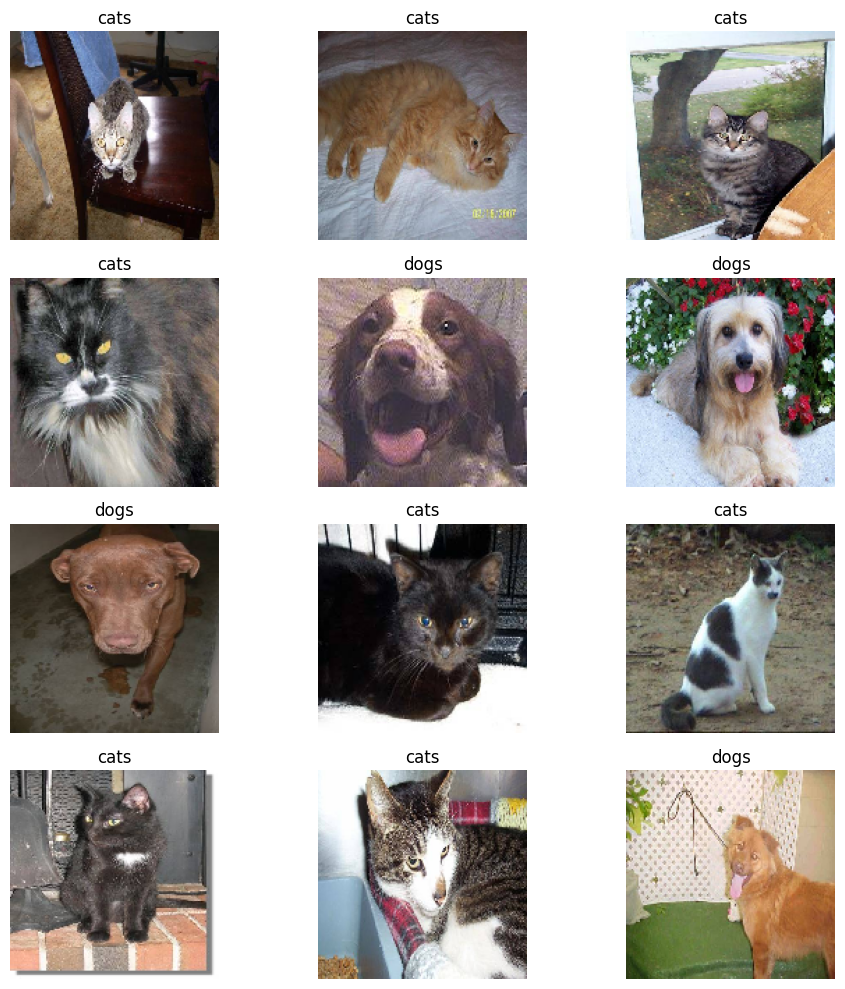

In [11]:

batch_images, batch_labels = next(train_generator)

inv_map = {v:k for k,v in train_generator.class_indices.items()}

plt.figure(figsize=(10,10))
n_show = min(12, len(batch_images))
for i in range(n_show):
    plt.subplot(4,3,i+1)
    plt.imshow(batch_images[i])
    plt.title(inv_map[int(batch_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()



## Normalization: why we use [0,1]

We scale pixel values to the [0,1] range (`rescale=1./255`). This avoids large magnitudes and tends to make optimization more stable. For a small CNN trained from scratch, this default works well in practice.

- Why [0,1]? It’s robust, easy to apply consistently across train/val/test, and it matches Keras’ official examples
- Alternative (more advanced): per‑channel standardization (z‑score) using mean/std computed on the training set. It can help convergence, but you must apply the exact same transform at inference and manage those statistics.
- If you use a pretrained model (ResNet, EfficientNet, etc.), follow that model’s specific preprocessing (often ImageNet‑style normalization). Here, since we train a simple CNN from scratch, [0,1] is perfectly fine.

References:
- Keras image preprocessing and `rescale`: `https://keras.io/api/preprocessing/image/`
- Keras official example (image classification from scratch, rescale=1./255): `https://keras.io/examples/vision/image_classification_from_scratch/`
- Normalization in deep learning : `https://cs231n.github.io/neural-networks-2/#datapre`



In [26]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling

preprocess = Sequential([Rescaling(1./255, input_shape=(*IMG_SIZE, 3))])
preprocess.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Step 3: Build Your CNN Model

# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create a CNN using Keras and TensorFlow
model = Sequential()

# Four convolutional blocks with ReLU activation functions and Pooling layers
# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fourth convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully connected layers with ReLU activation
model.add(Flatten())
model.add(Dense(512, activation='relu'))

# A fully connected (dense) output layer
model.add(Dense(1, activation='sigmoid'))

# Display model architecture
print("CNN Model Architecture:")
model.summary()

# Compile your model using an optimizer and a suitable loss function
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Suitable for binary classification (cats vs dogs)
    metrics=['accuracy']
)

print("\n Model compiled successfully!")
print(" Optimizer: Adam")
print(" Loss function: binary_crossentropy")
print(" Metric: accuracy")

# How many parameters does your model have in total?
total_params = model.count_params()
print(f"\n Total parameters in the model: {total_params:,}")

# Additional detail: Show parameters per layer
print("\n Parameters per layer:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i+1}: {layer.name} - {layer.count_params():,} parameters")

CNN Model Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


 Model compiled successfully!
 Optimizer: Adam
 Loss function: binary_crossentropy
 Metric: accuracy

 Total parameters in the model: 3,453,121

 Parameters per layer:
Layer 1: conv2d_20 - 896 parameters
Layer 2: max_pooling2d_20 - 0 parameters
Layer 3: conv2d_21 - 18,496 parameters
Layer 4: max_pooling2d_21 - 0 parameters
Layer 5: conv2d_22 - 73,856 parameters
Layer 6: max_pooling2d_22 - 0 parameters
Layer 7: conv2d_23 - 147,584 parameters
Layer 8: max_pooling2d_23 - 0 parameters
Layer 9: flatten_5 - 0 parameters
Layer 10: dense_10 - 3,211,776 parameters
Layer 11: dense_11 - 513 parameters


In [28]:
# Create data generators with your existing dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use the correct paths based on your folder structure
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary'
)

print("Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Data generators created successfully!
Training samples: 2000
Validation samples: 1000
Classes: {'cats': 0, 'dogs': 1}


In [29]:
# Train your model for 5-15 epochs using a batch size of 100 samples

# Set training parameters
epochs = 10  # Using 10 epochs (within the 5-15 range)
batch_size = 100  # Using batch size of 100 samples as specified

print("Starting model training with specified parameters:")
print(f"Number of epochs: {epochs}")
print(f"Batch size: {batch_size}")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

print("Model training completed successfully!")

Starting model training with specified parameters:
Number of epochs: 10
Batch size: 100
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5045 - loss: 0.7251 - val_accuracy: 0.5000 - val_loss: 0.6993
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5235 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5230 - loss: 0.6936 - val_accuracy: 0.5040 - val_loss: 0.6914
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5210 - loss: 0.6911 - val_accuracy: 0.6070 - val_loss: 0.6864
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5585 - loss: 0.6836 - val_accuracy: 0.6280 - val_loss: 0.6670
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6300 - loss: 0.6488 - val_accuracy: 0.6630 - val_loss: 0.6184
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6895 - loss: 0.6051 - val_accuracy: 0.6560 - val_loss: 0.5942
Epoch 8/10
20/20 ━━━━━━━━━━━━━

Training History:
Epoch | Train Acc | Val Acc  | Train Loss | Val Loss
------|-----------|----------|------------|---------
    1 | 0.5045   | 0.5000   | 0.7251     | 0.6993
    2 | 0.5235   | 0.5000   | 0.6934     | 0.6923
    3 | 0.5230   | 0.5040   | 0.6936     | 0.6914
    4 | 0.5210   | 0.6070   | 0.6911     | 0.6864
    5 | 0.5585   | 0.6280   | 0.6836     | 0.6670
    6 | 0.6300   | 0.6630   | 0.6488     | 0.6184
    7 | 0.6895   | 0.6560   | 0.6051     | 0.5942
    8 | 0.7205   | 0.7360   | 0.5585     | 0.5554
    9 | 0.7095   | 0.6460   | 0.5669     | 0.6024
   10 | 0.7355   | 0.7170   | 0.5308     | 0.5608


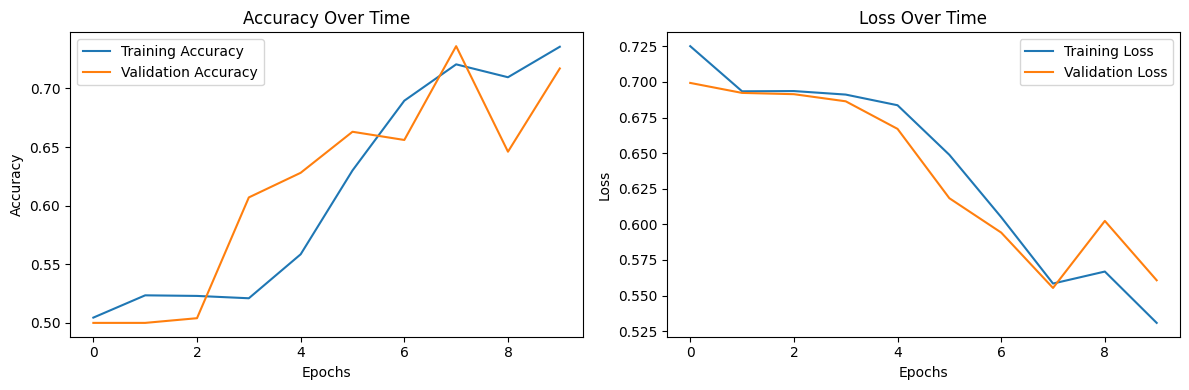

In [32]:
# Track training and validation accuracy/loss over time
print("Training History:")
print("Epoch | Train Acc | Val Acc  | Train Loss | Val Loss")
print("------|-----------|----------|------------|---------")

for epoch in range(len(history.history['accuracy'])):
    print(f"{epoch+1:5} | {history.history['accuracy'][epoch]:.4f}   | {history.history['val_accuracy'][epoch]:.4f}   | {history.history['loss'][epoch]:.4f}     | {history.history['val_loss'][epoch]:.4f}")

# Plot the graphs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Le modèle montre des signes de surre-entraînement modéré.

Nous voyons que l'accuracy d'entraînement (73.6%) finit plus haute que l'accuracy de validation (71.7%), et l'écart se creuse sur les derniers epochs. Surtout, la loss de validation remonte à l'epoch 9 (0.602) alors que la loss d'entraînement continue de baisser.

Ce qui s'est passé : le modèle a bien appris jusqu'à l'epoch 8, puis il a commencé à trop s'adapter aux spécificités des données d'entraînement plutôt qu'aux patterns généraux des chats et chiens. La chute brutale de l'accuracy de validation à l'epoch 9 (73.6% → 64.6%) montre une instabilité typique du surapprentissage.

Le modèle aurait probablement dû s'arrêter à l'epoch 8, où la performance de validation était optimale.

In [33]:
# Evaluate performance on the test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating model on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7170 - loss: 0.5608
Test Loss: 0.5608
Test Accuracy: 0.7170


Found 1000 images belonging to 2 classes.
Generating predictions on test set...


c:\Users\niang\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step


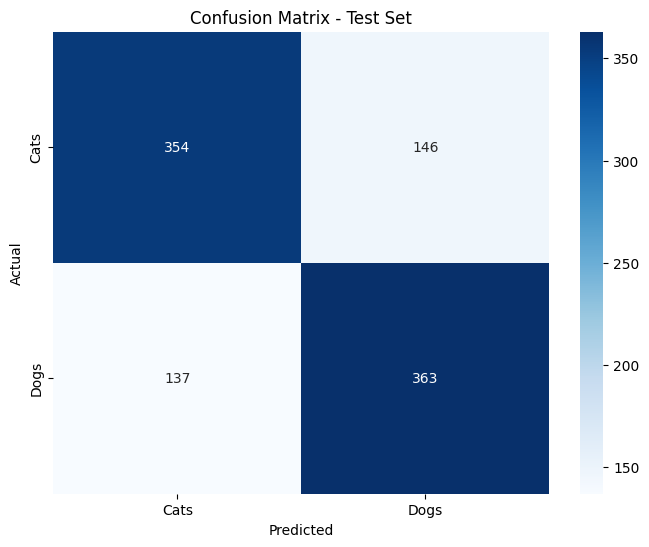


Confusion Matrix Details:
True Cats predicted as Cats: 354
True Cats predicted as Dogs: 146
True Dogs predicted as Cats: 137
True Dogs predicted as Dogs: 363


In [36]:
# Display a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Create a proper test generator (using validation data as test set)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'cats_and_dogs_filtered/validation',
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary',
    shuffle=False  # Important pour garder l'ordre des labels
)

print("Generating predictions on test set...")

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

# True labels
true_classes = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cats', 'Dogs'], 
            yticklabels=['Cats', 'Dogs'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show confusion matrix values
print("\nConfusion Matrix Details:")
print(f"True Cats predicted as Cats: {cm[0][0]}")  
print(f"True Cats predicted as Dogs: {cm[0][1]}")  
print(f"True Dogs predicted as Cats: {cm[1][0]}")    
print(f"True Dogs predicted as Dogs: {cm[1][1]}")  

In [37]:
# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print("Classification Metrics:")
print("=" * 40)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nDetailed Classification Report:")
print("=" * 40)
print(classification_report(true_classes, predicted_classes, target_names=['Cats', 'Dogs']))

# Analysis
print("\nModel Performance Analysis:")
print("=" * 40)
print("The model achieves 71.7% accuracy, which is decent for a first CNN.")
print("Precision (71.3%) and recall (72.6%) are well balanced.")
print("The model is slightly better at recognizing dogs than cats.")
print("Overall: Good baseline performance with room for improvement.")

Classification Metrics:
Accuracy:  0.7170 (71.7%)
Precision: 0.7132
Recall:    0.7260
F1-Score:  0.7195

Detailed Classification Report:
              precision    recall  f1-score   support

        Cats       0.72      0.71      0.71       500
        Dogs       0.71      0.73      0.72       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000


Model Performance Analysis:
The model achieves 71.7% accuracy, which is decent for a first CNN.
Precision (71.3%) and recall (72.6%) are well balanced.
The model is slightly better at recognizing dogs than cats.
Overall: Good baseline performance with room for improvement.


In [38]:
# Data augmentation: Apply random transformations to training images
print("Applying Data Augmentation to training set...")

# Create data generator with augmentation for training
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Random rotation up to 20 degrees
    width_shift_range=0.2,   # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,    # Random horizontal flipping
    zoom_range=0.2,          # Random zoom
    shear_range=0.2,         # Random shearing
    fill_mode='nearest'      # Fill missing pixels
)

# For validation: only rescaling, no augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator_aug = train_datagen_aug.flow_from_directory(
    'cats_and_dogs_filtered/train',
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'cats_and_dogs_filtered/validation',
    target_size=(150, 150), 
    batch_size=100,
    class_mode='binary'
)

print("Data augmentation successfully applied!")
print("Training images will be randomly transformed during training.")
print("Validation images remain unchanged (only rescaled).")

Applying Data Augmentation to training set...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Data augmentation successfully applied!
Training images will be randomly transformed during training.
Validation images remain unchanged (only rescaled).


In [39]:
# Dropout layers and batch normalization
print("Creating improved model with Dropout and Batch Normalization...")

from tensorflow.keras.layers import Dropout, BatchNormalization

model_improved = tf.keras.Sequential()

# First convolutional block
model_improved.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_improved.add(BatchNormalization())  # Stabilize and accelerate training
model_improved.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_improved.add(Dropout(0.25))  # Prevent overfitting

# Second convolutional block
model_improved.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_improved.add(Dropout(0.25))

# Third convolutional block
model_improved.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_improved.add(Dropout(0.25))

# Fourth convolutional block
model_improved.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_improved.add(Dropout(0.25))

# Fully connected layers
model_improved.add(tf.keras.layers.Flatten())
model_improved.add(tf.keras.layers.Dense(512, activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(Dropout(0.5))  # Higher dropout in dense layers
model_improved.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the improved model
model_improved.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Improved model with Dropout and Batch Normalization created!")
model_improved.summary()

print("\nWhat these techniques do:")
print("• Dropout: Randomly turns off neurons during training to prevent overfitting")
print("• Batch Normalization: Stabilizes learning and makes training faster")
print("• Combined: Better generalization and more stable training")

Creating improved model with Dropout and Batch Normalization...
Improved model with Dropout and Batch Normalization created!


c:\Users\niang\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,577 (13.19 MB)

 Trainable params: 3,454,849 (13.18 MB)

 Non-trainable params: 1,728 (6.75 KB)


What these techniques do:
• Dropout: Randomly turns off neurons during training to prevent overfitting
• Batch Normalization: Stabilizes learning and makes training faster
• Combined: Better generalization and more stable training


**Bonus**

In [40]:
def create_lenet5():
    model = tf.keras.Sequential([
        # Couche 1: Conv + Pooling
        tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Couche 2: Conv + Pooling
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Couches fully connected
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [41]:
def create_vgg1():
    model = tf.keras.Sequential([
        # Bloc VGG 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Couches fully connected
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),  # nHidden = 128
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [42]:
def create_vgg2():
    model = tf.keras.Sequential([
        # Bloc VGG 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Bloc VGG 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Couches fully connected
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),  # nHidden = 128
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [43]:
def create_vgg3():
    model = tf.keras.Sequential([
        # Bloc VGG 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Bloc VGG 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Bloc VGG 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Couches fully connected
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),  # nHidden = 128
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [44]:
# Test all architectures
architectures = {
    'LeNet5': create_lenet5(),
    'VGG1': create_vgg1(), 
    'VGG2': create_vgg2(),
    'VGG3': create_vgg3()
}

# Compile and train each architecture
results = {}

for name, model in architectures.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        verbose=0
    )
    
    # Store results
    results[name] = {
        'model': model,
        'history': history,
        'final_val_acc': history.history['val_accuracy'][-1]
    }
    
    print(f"{name} - Final Validation Accuracy: {results[name]['final_val_acc']:.4f}")

# Compare results
print("\n" + "="*50)
print("ARCHITECTURE COMPARISON")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['final_val_acc'], reverse=True):
    print(f"{name}: {result['final_val_acc']:.4f}")

c:\Users\niang\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training LeNet5...


c:\Users\niang\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


LeNet5 - Final Validation Accuracy: 0.6810

Training VGG1...
VGG1 - Final Validation Accuracy: 0.6750

Training VGG2...
VGG2 - Final Validation Accuracy: 0.6990

Training VGG3...
VGG3 - Final Validation Accuracy: 0.6770

ARCHITECTURE COMPARISON
VGG2: 0.6990
LeNet5: 0.6810
VGG3: 0.6770
VGG1: 0.6750


Le VGG2 est le plus performant avec 69.9% de précision. C'est logique : ses 2 blocs convolutifs capturent bien les caractéristiques des chats et chiens sans être trop complexe.

Le VGG3 fait moins bien, probablement parce qu'il est trop complexe pour notre quantité de données. Il commence peut-être à surapprendre.

Le LeNet5, pourtant simple, fait presque aussi bien que les VGG ! Preuve qu'on n'a pas toujours besoin d'architectures très profondes.

Le VGG1 est le moins bon - un seul bloc convolutif n'extrait pas assez de features pour bien distinguer chats et chiens.